In [1]:
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

# Chapter 02

This chapter introduces the concept of “the ladder of causation”. We focus on highlighting differences between three main concepts: associations, interventions and counterfactuals. We provide the reader with a couple of thought experiments to strengthen the understanding of these concepts and implement these experiments in Python. Finally, we demonstrate how counterfactuals can be used for model prediction explanations (e.g. in finance).

## Association

### Bookstore example

In [3]:
# First, we'll build a structural causal model (SCM)
class BookSCM:
    
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_0 = stats.uniform()
        self.u_1 = stats.norm()
        
    def sample(self, sample_size=100):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_0 = self.u_0.rvs(sample_size)
        u_1 = self.u_1.rvs(sample_size)
        a = u_0 > .61
        b = (a + .5 * u_1) > .2
        
        return a, b

In [4]:
# Let's initialize our SCM
scm = BookSCM(random_seed=45)

In [5]:
# ...and sample from it
buy_book_a, buy_book_b = scm.sample(100)

In [6]:
# Sanity check
buy_book_a.shape, buy_book_b.shape

((100,), (100,))

In [7]:
# Let's compute probabilities
proba_book_a = buy_book_a.sum() / buy_book_a.shape[0]
proba_book_b = buy_book_b.sum() / buy_book_b.shape[0]

print(f'Probability of buying book A: {proba_book_a:0.3f}')
print(f'Probability of buying book B: {proba_book_b:0.3f}')

# ...and conditional probailities
proba_book_a_given_book_b = np.where(buy_book_b, buy_book_a, 0).sum() / buy_book_b.sum()
proba_book_b_given_book_a = np.where(buy_book_a, buy_book_b, 0).sum() / buy_book_a.sum()

print(f'Probability of buying book A given B: {proba_book_a_given_book_b:0.3f}')
print(f'Probability of buying book B given A: {proba_book_b_given_book_a:0.3f}')

Probability of buying book A: 0.390
Probability of buying book B: 0.580
Probability of buying book A given B: 0.638
Probability of buying book B given A: 0.949


## Intervention

In [20]:
SAMPLE_SIZE = 100

np.random.seed(45)

u_0 = np.random.randn(SAMPLE_SIZE)
u_1 = np.random.randn(SAMPLE_SIZE)
a = u_0
b = 5 * a + u_1

r, p = stats.pearsonr(a, b)

print(f'Mean of B before any intervention: {b.mean():.3f}')
print(f'Variance of B before any intervention: {b.var():.3f}')
print(f'Correlation between A and B:\nr = {r:.3f}; p = {p:.3f}\n')

a = np.array([1.5] * SAMPLE_SIZE)
b = 5 * a + u_1

print(f'Mean of B after the intervention on A: {b.mean():.3f}')
print(f'Variance of B after the intervention on A: {b.var():.3f}\n')

a = u_0
b = np.random.randn(SAMPLE_SIZE)

r, p = stats.pearsonr(a, b)

print(f'Mean of B after the intervention on B: {b.mean():.3f}')
print(f'Variance of B after the intervention on B: {b.var():.3f}')
print(f'Correlation between A and B after intervening on B:\nr = {r:.3f}; p = {p:.3f}\n')

Mean of B before any intervention: -0.620
Variance of B before any intervention: 22.667
Correlation between A and B:
r = 0.978; p = 0.000

Mean of B after the intervention on A: 7.575
Variance of B after the intervention on A: 1.003

Mean of B after the intervention on B: 0.186
Variance of B after the intervention on B: 0.995
Correlation between A and B after intervening on B:
r = -0.023; p = 0.821



## Counterfactuals

We'll use the following SCM:

$$\large Y := TU + (T-1)(U-1)$$

In [110]:
class CounterfactualSCM:
    
    def abduct(self, t, y):
        return (t + y - 1)/(2*t - 1)
    
    def modify(self, t):
        return lambda u: t * u + (t - 1) * (u - 1)
        
    def predict(self, u, t):
        return self.modify(t)(u)

In [123]:
fiber = CounterfactualSCM()
t = 1
y = 1

In [124]:
u = fiber.abduct(t=t, y=y)
u

1.0

In [125]:
fiber.predict(u=u, t=0)

0.0

## Causation without correlation - plots

### Non-monotonic case

In [30]:
x = np.random.uniform(-2, 2, 5000)
y = x**2 + 0.2*np.random.randn(len(x))

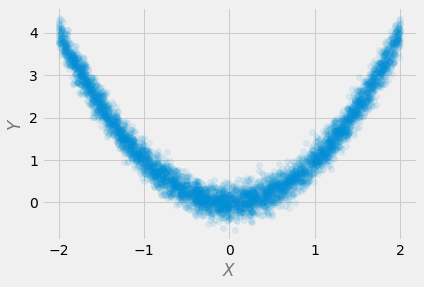

In [14]:
plt.scatter(x, y, alpha=.1)
plt.xlabel('$X$', alpha=.5)
plt.ylabel('$Y$', alpha=.5)
plt.show()

In [15]:
# Correlation coefficient
stats.spearmanr(x, y)

SpearmanrResult(correlation=-0.017571125214845006, pvalue=0.21414381254206408)

### Sneaky sampling case

In [61]:
# Get initial x
x = np.random.uniform(-2, 2, 5000)

# Filter samples
x = x[np.where((x < -1.9) | (x > 1.9), True, False)]

# Get y
y = x**2 + 0.2*np.random.randn(len(x))

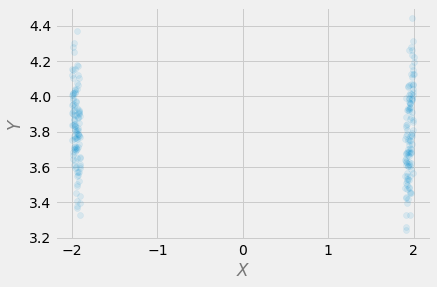

In [17]:
plt.scatter(x, y, alpha=.1)
plt.xlabel('$X$', alpha=.5)
plt.ylabel('$Y$', alpha=.5)
plt.show()

In [18]:
# Correlation coefficient
stats.spearmanr(x, y)

SpearmanrResult(correlation=0.0075097809299378045, pvalue=0.9092243672544423)

### Invisible equilibrium causation

In [155]:
# System in equilibrium
z = np.random.randn(1000)
x = -z
y = x + z

In [156]:
# All y's are 0 -> no change in Y when X changes
np.unique(y)

array([0.])

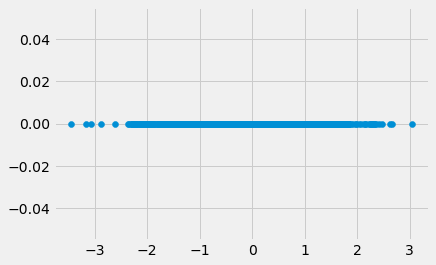

In [167]:
plt.scatter(x, y)
plt.show()

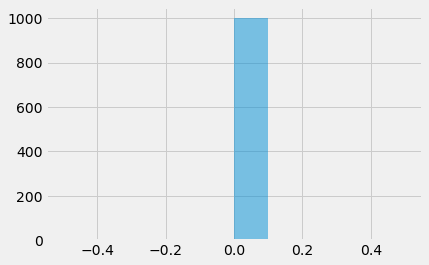

In [157]:
plt.hist(y, alpha=.5)
plt.show()

In [162]:
# System under two different interventions
z = np.random.randn(1000)
x1 = 1
x2 = 3
y1 = x1 + z
y2 = x2 + z

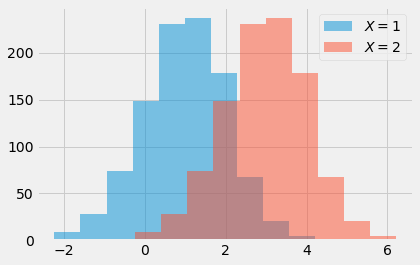

In [163]:
plt.hist(y1, label="$X=1$", alpha=.5)
plt.hist(y2, label="$X=2$", alpha=.5)
plt.legend()
plt.show()